# sistem rekomendasi content-based filtering

## import

In [23]:
!pip install Sastrawi

import pandas as pd
import numpy as np
from zipfile import ZipFile
from pathlib import Path

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from sklearn.metrics.pairwise import cosine_similarity

%matplotlib inline
sns.set_palette('Set1')
sns.set()

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

tv = TfidfVectorizer(max_features=5000)
stem = StemmerFactory().create_stemmer()
stopword = StopWordRemoverFactory().create_stop_word_remover()

import nltk
nltk.download('punkt')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## prepare data

In [6]:
df = pd.read_csv('data_hotel_traveloka.csv')
df.head()

,city,name,displayName,region,starRating,userRating,numReviews,userRatingInfo,latitude,longitude,hotelFeatures,prices
0,Jakarta,The Sultan Hotel & Residence Jakarta,The Sultan Hotel Jakarta,"Senayan, Jakarta",5.0,8.6,7247.0,Mengesankan,-6.216947,106.809331,"Bayar saat Check-in, Restoran show cooking, Wi...",7175300
1,Jakarta,Aryaduta Suite Semanggi,Aryaduta Suite Semanggi,"Karet Semanggi, Jakarta",4.0,8.5,4882.0,Mengesankan,-6.219991,106.816117,"Squash, Area main anak, Tennis, Layanan pijat,...",7202361
2,Jakarta,Aloft South Jakarta,Aloft South Jakarta,"Cilandak Timur, Jakarta",4.0,8.9,467.0,Mengesankan,-6.291784,106.816294,"Bar, Sewa mobil, Pusat kebugaran, Bilyar, Bar ...",3884100
3,Jakarta,"The Langham, Jakarta","The Langham, Jakarta","Senayan, Jakarta",5.0,8.8,340.0,Mengesankan,-6.227097,106.806396,"Restoran show cooking, Aktivitas outdoor, Klub...",23490093
4,Jakarta,"Hotel Mulia Senayan, Jakarta","Hotel Mulia Senayan, Jakarta","Senayan, Jakarta",5.0,8.7,1540.0,Mengesankan,-6.215131,106.797045,"Bar, Tennis, Fasilitas bisnis, Lapangan tennis...",16334999


## data preprocessing

### remove duplicates

In [7]:
jumlah_duplikat = df.duplicated().sum()
print("Jumlah data duplikat: ", jumlah_duplikat)

Jumlah data duplikat:  37


In [8]:
df = df.drop_duplicates()
print("Jumlah data duplikat setelah penghapusan:", df.duplicated().sum())

Jumlah data duplikat setelah penghapusan: 0


### removing Null/NaN rows

In [9]:
print("Jumlah baris dengan nilai null sebelum penghapusan:", df.isnull().sum())

Jumlah baris dengan nilai null sebelum penghapusan: city                0
name                0
displayName         0
region              0
starRating          0
userRating         13
numReviews          2
userRatingInfo     13
latitude            0
longitude           0
hotelFeatures     105
prices              0
dtype: int64


In [10]:
df = df.dropna()
print("Jumlah baris dengan nilai null setelah penghapusan:", df.isnull().sum())

Jumlah baris dengan nilai null setelah penghapusan: city              0
name              0
displayName       0
region            0
starRating        0
userRating        0
numReviews        0
userRatingInfo    0
latitude          0
longitude         0
hotelFeatures     0
prices            0
dtype: int64


### remove unused columns

In [1]:
# df = df.drop('id', axis=1)

In [11]:
df.head()

,city,name,displayName,region,starRating,userRating,numReviews,userRatingInfo,latitude,longitude,hotelFeatures,prices
0,Jakarta,The Sultan Hotel & Residence Jakarta,The Sultan Hotel Jakarta,"Senayan, Jakarta",5.0,8.6,7247.0,Mengesankan,-6.216947,106.809331,"Bayar saat Check-in, Restoran show cooking, Wi...",7175300
1,Jakarta,Aryaduta Suite Semanggi,Aryaduta Suite Semanggi,"Karet Semanggi, Jakarta",4.0,8.5,4882.0,Mengesankan,-6.219991,106.816117,"Squash, Area main anak, Tennis, Layanan pijat,...",7202361
2,Jakarta,Aloft South Jakarta,Aloft South Jakarta,"Cilandak Timur, Jakarta",4.0,8.9,467.0,Mengesankan,-6.291784,106.816294,"Bar, Sewa mobil, Pusat kebugaran, Bilyar, Bar ...",3884100
3,Jakarta,"The Langham, Jakarta","The Langham, Jakarta","Senayan, Jakarta",5.0,8.8,340.0,Mengesankan,-6.227097,106.806396,"Restoran show cooking, Aktivitas outdoor, Klub...",23490093
4,Jakarta,"Hotel Mulia Senayan, Jakarta","Hotel Mulia Senayan, Jakarta","Senayan, Jakarta",5.0,8.7,1540.0,Mengesankan,-6.215131,106.797045,"Bar, Tennis, Fasilitas bisnis, Lapangan tennis...",16334999


## data details

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 753 entries, 0 to 903
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   city            753 non-null    object 
 1   name            753 non-null    object 
 2   displayName     753 non-null    object 
 3   region          753 non-null    object 
 4   starRating      753 non-null    float64
 5   userRating      753 non-null    float64
 6   numReviews      753 non-null    float64
 7   userRatingInfo  753 non-null    object 
 8   latitude        753 non-null    float64
 9   longitude       753 non-null    float64
 10  hotelFeatures   753 non-null    object 
 11  prices          753 non-null    int64  
dtypes: float64(5), int64(1), object(6)
memory usage: 76.5+ KB


In [13]:
df.shape

(753, 12)

## EDA

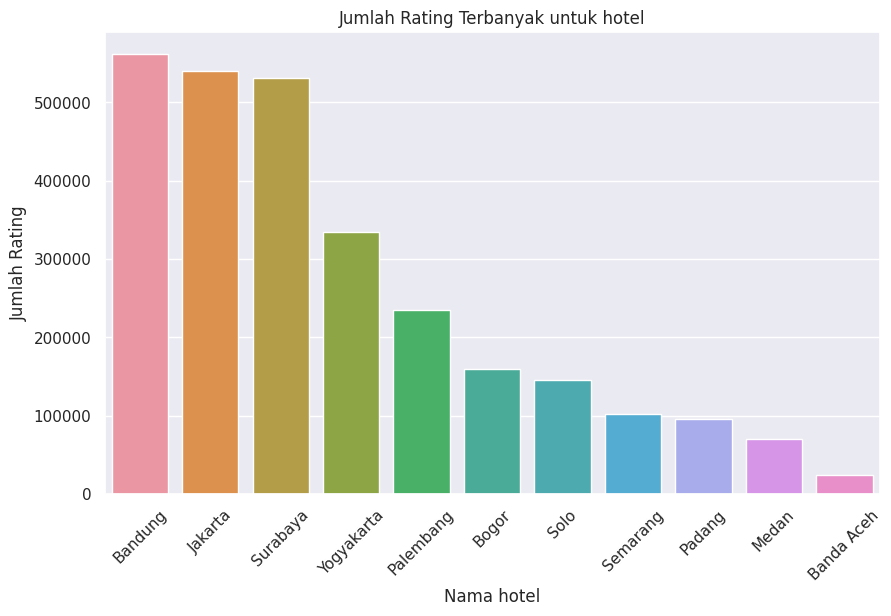

In [14]:
top_10 = df.groupby('city')['numReviews'].sum().reset_index()
top_10 = top_10.sort_values('numReviews', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=top_10, x='city', y='numReviews')
plt.xticks(rotation=45)
plt.xlabel('Nama hotel')
plt.ylabel('Jumlah Rating')
plt.title('Jumlah Rating Terbanyak untuk hotel')
plt.show()

## prepraring data for model

### cleaning "hotelFeatures" 
because, it's valueable for the model later

In [15]:
df['hotelFeatures'] = df['hotelFeatures'].str.replace(',', '')
df.head()

,city,name,displayName,region,starRating,userRating,numReviews,userRatingInfo,latitude,longitude,hotelFeatures,prices
0,Jakarta,The Sultan Hotel & Residence Jakarta,The Sultan Hotel Jakarta,"Senayan, Jakarta",5.0,8.6,7247.0,Mengesankan,-6.216947,106.809331,Bayar saat Check-in Restoran show cooking Wine...,7175300
1,Jakarta,Aryaduta Suite Semanggi,Aryaduta Suite Semanggi,"Karet Semanggi, Jakarta",4.0,8.5,4882.0,Mengesankan,-6.219991,106.816117,Squash Area main anak Tennis Layanan pijat Dap...,7202361
2,Jakarta,Aloft South Jakarta,Aloft South Jakarta,"Cilandak Timur, Jakarta",4.0,8.9,467.0,Mengesankan,-6.291784,106.816294,Bar Sewa mobil Pusat kebugaran Bilyar Bar di k...,3884100
3,Jakarta,"The Langham, Jakarta","The Langham, Jakarta","Senayan, Jakarta",5.0,8.8,340.0,Mengesankan,-6.227097,106.806396,Restoran show cooking Aktivitas outdoor Klub k...,23490093
4,Jakarta,"Hotel Mulia Senayan, Jakarta","Hotel Mulia Senayan, Jakarta","Senayan, Jakarta",5.0,8.7,1540.0,Mengesankan,-6.215131,106.797045,Bar Tennis Fasilitas bisnis Lapangan tennis ou...,16334999


## method for preprocessing data for the model itself

In [16]:
def preprocessing(data):
    data = data.lower()
    data = stem.stem(data)
    data = stopword.remove(data)
    return data

In [17]:
cbf_data = df.copy()
cbf_data['Tags'] = cbf_data['hotelFeatures']
cbf_data.drop(['name','region','starRating',
               'userRating','numReviews','userRatingInfo',
               'latitude','longitude','hotelFeatures',
               'prices'],axis=1,inplace=True)
cbf_data

,city,displayName,Tags
0,Jakarta,The Sultan Hotel Jakarta,Bayar saat Check-in Restoran show cooking Wine...
1,Jakarta,Aryaduta Suite Semanggi,Squash Area main anak Tennis Layanan pijat Dap...
2,Jakarta,Aloft South Jakarta,Bar Sewa mobil Pusat kebugaran Bilyar Bar di k...
3,Jakarta,"The Langham, Jakarta",Restoran show cooking Aktivitas outdoor Klub k...
4,Jakarta,"Hotel Mulia Senayan, Jakarta",Bar Tennis Fasilitas bisnis Lapangan tennis ou...
...,...,...,...
899,Surabaya,D'Carol Hotel Surabaya,Bayar saat Check-in
900,Surabaya,La Lisa Hotel Surabaya,Bayar saat Check-in Aktivitas outdoor Sewa mob...
901,Surabaya,Yello Hotel Jemursari,Layanan pijat Ruangan game Check-out ekspress Spa
902,Surabaya,Sumi Hotel Surabaya,Sewa mobil


In [18]:
cbf_data.Tags = cbf_data.Tags.apply(preprocessing)
cbf_data

,city,displayName,Tags
0,Jakarta,The Sultan Hotel Jakarta,bayar check-in restoran show cooking winery da...
1,Jakarta,Aryaduta Suite Semanggi,squash area main anak tennis layan pijat dapur...
2,Jakarta,Aloft South Jakarta,bar sewa mobil pusat bugar bilyar bar kolam re...
3,Jakarta,"The Langham, Jakarta",restoran show cooking aktivitas outdoor klub s...
4,Jakarta,"Hotel Mulia Senayan, Jakarta",bar tennis fasilitas bisnis lapang tennis outd...
...,...,...,...
899,Surabaya,D'Carol Hotel Surabaya,bayar check-in
900,Surabaya,La Lisa Hotel Surabaya,bayar check-in aktivitas outdoor sewa mobil spa
901,Surabaya,Yello Hotel Jemursari,layan pijat ruang game check-out ekspress spa
902,Surabaya,Sumi Hotel Surabaya,sewa mobil


In [19]:
vectors = tv.fit_transform(cbf_data.Tags).toarray()
vectors

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.34096987],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [20]:
similarity = cosine_similarity(vectors)
similarity[0][1:10]

array([0.25920224, 0.08778075, 0.3360852 , 0.32309742, 0.04110825,
       0.17392255, 0.15997296, 0.14726899, 0.19992052])

In [31]:
def recommend_by_content_based_filtering(kebutuhan):
    # Mengubah kalimat input menjadi daftar kata kunci
    keywords = nltk.word_tokenize(kebutuhan)
    
    recommended_kebutuhans = []
    
    for i, tags in enumerate(cbf_data['Tags']):
        # Mengubah tags menjadi daftar kata-kata
        tags_list = nltk.word_tokenize(tags)
        
        # Mencari kata-kata yang cocok dengan kata-kata kunci
        matched_keywords = [keyword for keyword in keywords if keyword in tags_list]
        
        # Menentukan tingkat kesamaan berdasarkan jumlah kata yang cocok
        similarity_score = len(matched_keywords)
        
        # Menambahkan kebutuhan yang cocok ke dalam daftar rekomendasi
        recommended_kebutuhans.append([tags, similarity_score])
    
    # Mengurutkan berdasarkan tingkat kesamaan secara menurun
    recommended_kebutuhans = sorted(recommended_kebutuhans, key=lambda x: x[1], reverse=True)
    
    # Mengambil 10 rekomendasi teratas
    recommended_kebutuhans = recommended_kebutuhans[:10]
    
    return recommended_kebutuhans


## testing

In [35]:
recommend_by_content_based_filtering('bayar aerobik pusat bugar')

[['bayar check-in aerobik restoran show cooking ruang santai klub anak aksesibel sandang disabilitas pusat bugar bar',
  4],
 ['bayar check-in aerobik restoran show cooking ruang santai klub anak aksesibel sandang disabilitas pusat bugar bar',
  4],
 ['aerobik winery layan pijat pusat bugar bar kolam renang aksesibel sandang disabilitas pusat bugar bar',
  3],
 ['aerobik winery pusat bugar fasilitas bisnis aksesibel sandang disabilitas check-out ekspress pusat bugar bar',
  3],
 ['bayar check-in layan pijat bar kolam renang pusat bugar bar', 3],
 ['aerobik bar area main anak fasilitas bisnis bar kolam renang aksesibel sandang disabilitas pusat bugar bar',
  3],
 ['aerobik aktivitas outdoor handuk pantai layan pijat pusat bugar aksesibel sandang disabilitas check-out ekspress pusat bugar',
  3],
 ['bayar check-in layan pijat pusat bugar aksesibel sandang disabilitas spa pusat bugar',
  3],
 ['badminton aerobik bar tennis bilyar aksesibel sandang disabilitas pusat bugar bar',
  3],
 ['ba

## misc